# Random Forest Classification

https://jakevdp.github.io/PythonDataScienceHandbook/05.08-random-forests.html

### Ordforklaring (ChatGPT)


> Et beslutningstræ i datalogi er en struktureret model, der bruges til at træffe beslutninger ved at stille en række spørgsmål
> og følge forskellige grene af træet baseret på svarene.

> En tilfældig skov i datalogi er en ensemblemetode, der består af flere beslutningstræer, 
> hvor hvert træ trænes uafhængigt og kombineres for at opnå bedre præstationer.

> Bagging (Bootstrap Aggregating) er en teknik i datalogi, hvor flere modeller trænes uafhængigt på forskellige sub-sæt af 
> træningsdata og deres forudsigelser kombineres for at reducere overfitting og forbedre generaliseringsevnen.

I dette afsnit vil vi anvende scikit-learn til random forest klassifikation på vindataene. Dvs vi vil køre algoritmer, som ved hjælp af bagging bygger beslutningstræer, som samles i skove. Klassifikationen sker ved at køre input gennem alle beslutningstræerne i skoven og derudfra bestemme en klasse. Algoritmen angiver den mest sandsynlige klasse ud fra input.


### Fremgangsmåde

Vi anvender følgende fremgangsmåde for at finde den bedst mulige model (inden for de begrænsninger, der er i forhold til tid og evner).

1. Indlæs data og lav en lille smule databehandling.
2. Lav en baseline model med standardparametrene.
3. Undersøg om tuning af hyperparametre kan forbedre modellen.



## Indlæsning af data

In [1]:
# Biblioteker importeres
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneOut, RandomizedSearchCV, cross_val_score

In [2]:
# Indlæs data
df = pd.read_csv('WineQT.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1143 non-null   float64
 1   volatile acidity      1143 non-null   float64
 2   citric acid           1143 non-null   float64
 3   residual sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free sulfur dioxide   1143 non-null   float64
 6   total sulfur dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   pH                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
 12  Id                    1143 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 116.2 KB


In [4]:
# Vi skal ikke bruge kolonnen 'Id'
df.drop(columns=['Id'], inplace=True)

In [5]:
# Vi gemmer input features i X og output i y
features = df.columns[:-1]
X = df[features]
y = df['quality']

## Baseline Random Forest model

In [6]:
# Vi laver en Random Forest Classifier
rf_clf = RandomForestClassifier()
rf_clf.fit(X, y)

RandomForestClassifier()

#### Først laver vi krydsvalidering med "Leave One Out"-metoden

In [7]:
cv = LeaveOneOut()
cv_score = cross_val_score(rf_clf, X, y, cv=cv)

In [8]:
print(f"Standardscoren ved leave one out krydsvalidering er: {cv_score.mean():.2%}")

Standardscoren ved leave one out krydsvalidering er: 68.50%


In [9]:
cross_validation_scores = {}
cross_validation_scores['Leave One Out'] = cv_score.mean()

#### Forsøg med andre krydsvalideringsteknikker

På nærværende maskine tog det over 6 minutter at udregne krydsvalideringsscorene. Når vi skal tune hyperparametre senere, bliver det meget lang tid. Derfor forsøger vi at se, hvad det "koster" at lave en grovere krydsvalidering.

In [10]:
k_vals = range(2,11)

for k in k_vals:
    cv_score = []
    for _ in range(100 // k):
        cv_score.extend(list(cross_val_score(rf_clf, X, y, cv=k)))
    cross_validation_scores[f'K-fold CV. K = {k}'] = np.mean(cv_score)

c:\Python312\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=7.
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=7.
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=7.
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=7.
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=7.
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The lea

In [11]:
cross_validation_scores

{'Leave One Out': 0.6850393700787402,
 'K-fold CV. K = 2': 0.5662862356557627,
 'K-fold CV. K = 3': 0.5741138418303772,
 'K-fold CV. K = 4': 0.5595368666421298,
 'K-fold CV. K = 5': 0.5871420363134913,
 'K-fold CV. K = 6': 0.5724482180582345,
 'K-fold CV. K = 7': 0.5766126815831825,
 'K-fold CV. K = 8': 0.5786805623953512,
 'K-fold CV. K = 9': 0.580211564463533,
 'K-fold CV. K = 10': 0.5754523264683449}

Vi kan se, at "leave one out" giver en markant højere score. Derfor ville det være mest korrekt at benytte denne metode. På grund af hardwarebegrænsninger, og fordi der primært er et undervisningsmål med denne øvelse, vælger vi alligvel en krydsvalideringsmetode, som ikke er optimal. Af de mindre optimale løsninger vælger vi K = 5, da den giver en god score blandt de mindre gode scorer, og fordi den beregningsmæssigt er en del billigere end "leave one out".

For at kompensere for en mulig høj varians, kører vi 5-fold krydsvalidering 20 gange hver gang og tager gennemsnittet af scorene.

In [12]:
def score_model(**kwargs):
    rf_model = RandomForestClassifier(**kwargs)
    rf_model.fit(X, y)
    cv_score = []
    for _ in range(20):
        cv_score.extend(list(cross_val_score(rf_model, X, y, cv=5)))
    return np.mean(cv_score)
    

In [13]:
print(f"Standardscoren ved 5-fold krydsvalidering med 20 gentagelser er: {score_model():.2%}")

Standardscoren ved 5-fold krydsvalidering med 20 gentagelser er: 58.80%


## Tuning af hyperparametre

Relevante hyperparametre inkluderer:
- Antallet af træer i skoven `n_estimators`
- Den maksimale dybde af træerne `max_depth`
- Det minimale antal samples (datapunkter), der skal til for at opdele en intern knude i flere knuder (oprette en ny forgrening) `min_samples_split`
- Det minimale antal samples, som er nødvendig for at være et blad `min_samples_leaf`
- Det maksimale antal features, som indgår i vurderingen af den bedste opsplitning af knuderne `max_features`
- Det maksimale antal blade på hvert træ `max_leaf_nodes`

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [14]:
# Vi gemmer hyperparametrene i en dictionary
hyperparameters = {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_leaf_nodes': None}

Strategien for at tune hyperparametrene er at teste forskellige værdier af hver enkelt parameter, med udgangspunkt i standardværdierne.

Hver gang noteres den tilhørende score.

In [15]:
# De værdier, som vi vil teste
n_estimators = [50, 100, 200, 500]
max_depth = [10, 20, 30, None]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
max_features = ['sqrt', 'log2', None]
max_leaf_nodes = [10, 25, 50, None]

Ovenstående giver 1728 mulige kombinationer. Med en kørselstid på ca 30 sekunder per kombination, skal vi køre i mere en 14 timer, hvilket ikke er formålstjenestligt i denne sammenhæng. Derfor vælger vi først en løsning, hvor vi ændrer en variabel ad gangen og på den måde "bygger" et optimalt parametersæt (med de begrænsninger, der ligger i det). Vi anvender en "grådig" tilgang, hvor vi optimerer en parameter ad gangen og kører videre med den nyfunde "optimale" parameter.

In [16]:
scores = pd.DataFrame(columns=['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'max_features', 'max_leaf_nodes', 'score'])

In [17]:
# Vi ændrer antallet af træer
for n_est in n_estimators:
    h_params = hyperparameters.copy()
    h_params['n_estimators'] = n_est
    h_params['score'] = score_model(**h_params)
    scores.loc[len(scores)] = h_params

In [18]:
scores.sort_values(by='score', ascending=False).head(4)

,n_estimators,max_depth,min_samples_split,min_samples_leaf,max_features,max_leaf_nodes,score
2,200,None,2,1,sqrt,None,0.587538
3,500,None,2,1,sqrt,None,0.586793
1,100,None,2,1,sqrt,None,0.583950
0,50,None,2,1,sqrt,None,0.575551


<Axes: xlabel='n_estimators', ylabel='score'>

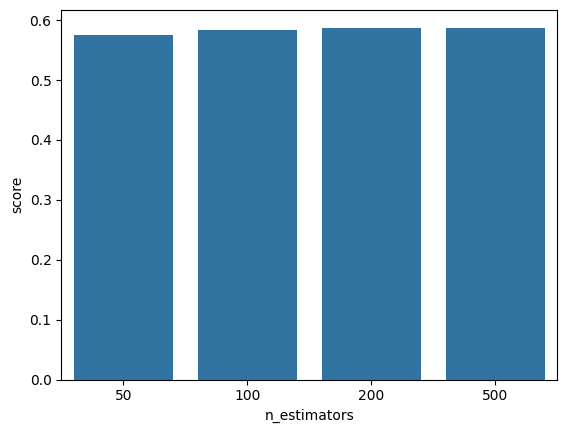

In [19]:
sns.barplot(x='n_estimators', y='score', data=scores)


Vi får den højeste score, når antallet af træer er 200. Den værdi kører vi videre med.

In [20]:
hyperparameters['n_estimators'] = 200

In [21]:
# Vi ændrer den maksimale dybde af træerne
for max_dpth in max_depth:
    h_params = hyperparameters.copy()
    h_params['max_depth'] = max_dpth
    h_params['score'] = score_model(**h_params)
    scores.loc[len(scores)] = h_params

In [22]:
scores.sort_values(by='score', ascending=False).head()

,n_estimators,max_depth,min_samples_split,min_samples_leaf,max_features,max_leaf_nodes,score
4,200,10,2,1,sqrt,None,0.590074
7,200,None,2,1,sqrt,None,0.589025
6,200,30,2,1,sqrt,None,0.587929
2,200,None,2,1,sqrt,None,0.587538
3,500,None,2,1,sqrt,None,0.586793


Af de værdier for den maksimale dybde, som vi har undersøgt, er 10 den værdi, som giver den højeste score. Vi kører videre med denne score.

In [23]:
hyperparameters['max_depth'] = 10

In [24]:
# Vi ændrer det minimale antal samples (datapunkter), der skal til for at opdele en intern knude i flere knuder
for min_split in min_samples_split:
    h_params = hyperparameters.copy()
    h_params['min_samples_split'] = min_split
    h_params['score'] = score_model(**h_params)
    scores.loc[len(scores)] = h_params

In [25]:
scores.sort_values(by='score', ascending=False).head()

,n_estimators,max_depth,min_samples_split,min_samples_leaf,max_features,max_leaf_nodes,score
10,200,10,10,1,sqrt,None,0.591382
8,200,10,2,1,sqrt,None,0.590336
4,200,10,2,1,sqrt,None,0.590074
9,200,10,5,1,sqrt,None,0.589285
7,200,None,2,1,sqrt,None,0.589025


Det antal samples, som giver den højeste score er 10. Det kører vi videre med.

In [26]:
hyperparameters['min_samples_split'] = 10

In [27]:
# Vi ændrer det minimale antal samples, som er nødvendig for at være et blad
for min_leaf in min_samples_leaf:
    h_params = hyperparameters.copy()
    h_params['min_samples_leaf'] = min_leaf
    h_params['score'] = score_model(**h_params)
    scores.loc[len(scores)] = h_params

In [28]:
scores.sort_values(by='score', ascending=False).head()

,n_estimators,max_depth,min_samples_split,min_samples_leaf,max_features,max_leaf_nodes,score
12,200,10,10,2,sqrt,None,0.596368
13,200,10,10,4,sqrt,None,0.593343
10,200,10,10,1,sqrt,None,0.591382
8,200,10,2,1,sqrt,None,0.590336
4,200,10,2,1,sqrt,None,0.590074


Det antal samples, som giver den højeste score er 2. Det kører vi videre med.

In [29]:
hyperparameters['min_samples_leaf'] = 2

In [30]:
# Vi ændrer det maksimale antal features, som indgår i vurderingen af den bedste opsplitning af knuderne
for max_ft in max_features:
    h_params = hyperparameters.copy()
    h_params['max_features'] = max_ft
    h_params['score'] = score_model(**h_params)
    scores.loc[len(scores)] = h_params

In [31]:
scores.sort_values(by='score', ascending=False).head()

,n_estimators,max_depth,min_samples_split,min_samples_leaf,max_features,max_leaf_nodes,score
12,200,10,10,2,sqrt,None,0.596368
15,200,10,10,2,log2,None,0.593349
13,200,10,10,4,sqrt,None,0.593343
14,200,10,10,2,sqrt,None,0.593218
10,200,10,10,1,sqrt,None,0.591382


Det er ikke nødvendigt at ændre på udvælgelsen af antal features.

In [32]:
# Vi ændrer det maksimale antal blade på træerne
for max_leaf in max_leaf_nodes:
    h_params = hyperparameters.copy()
    h_params['max_leaf_nodes'] = max_leaf
    h_params['score'] = score_model(**h_params)
    scores.loc[len(scores)] = h_params

In [33]:
scores.sort_values(by='score', ascending=False).head()

,n_estimators,max_depth,min_samples_split,min_samples_leaf,max_features,max_leaf_nodes,score
12,200,10,10,2,sqrt,None,0.596368
19,200,10,10,2,sqrt,50,0.594084
20,200,10,10,2,sqrt,None,0.593605
15,200,10,10,2,log2,None,0.593349
13,200,10,10,4,sqrt,None,0.593343


Her er heller ingen ændringer i forhold til standardværdierne.

### Opsamling på tuning af hyperparametre

Standardscoren for random forest classifier modellen var

- 68.9% med leave one out krydsvalidering
- 58.4% med 5-folds krydsvalidering

Med tuning af hyperparametre var scoren

- 59.5% med 5-folds krydsvalidering

### Alternativ tilgang til optimeringen

Scikit learn pakken har et bud på en anden tilgang til tuning af hyperparametre, nemlig _randomized search cross validation_.

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

Idéen er stadig, at det er for omkostningstungt at teste alle 1728 kombinationer af værdisæt for parametrene. I stedet for at lave en grådig algoritme, som optimerer en paramterer ad gangen, vælges et fast antal kombinationer ud og den optimale kombination vælges derudfra.

In [47]:
test_parameters = {'n_estimators': n_estimators, 'max_depth': max_depth, 'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf, 'max_features': max_features, 'max_leaf_nodes': max_leaf_nodes}
rf_clf = RandomForestClassifier()
def randomized_search(no_combs):
    rf_cv = RandomizedSearchCV(rf_clf, test_parameters, cv=5, n_iter=no_combs)
    rf_cv.fit(X,y)
    return (rf_cv.best_params_, rf_cv.best_score_)

In [48]:
randomized_df = pd.DataFrame(columns=['no_combs', 'n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'max_features', 'max_leaf_nodes', 'score'])

In [49]:
for n_combs in [10, 25, 50, 100, 200]:
    result = randomized_search(n_combs)
    input = result[0]
    input['no_combs'] = n_combs
    input['score'] = result[1]
    randomized_df.loc[len(randomized_df)] = input

Resultaterne af den ramdomiserede afprøvning af parametre giver en lidt højere score. 

In [37]:
randomized_df.sort_values(by='score', ascending=False).head()

,no_combs,n_estimators,max_depth,min_samples_split,min_samples_leaf,max_features,max_leaf_nodes,score
4,200,50,30,10,4,log2,None,0.609814
3,100,100,20,10,2,sqrt,50,0.604497
2,50,100,30,5,1,log2,50,0.600176
1,25,200,10,5,4,log2,None,0.600165
0,10,500,30,5,2,sqrt,50,0.598399


In [40]:
scores.sort_values(by='score', ascending=False).head()

,n_estimators,max_depth,min_samples_split,min_samples_leaf,max_features,max_leaf_nodes,score
12,200,10,10,2,sqrt,None,0.596368
19,200,10,10,2,sqrt,50,0.594084
20,200,10,10,2,sqrt,None,0.593605
15,200,10,10,2,log2,None,0.593349
13,200,10,10,4,sqrt,None,0.593343


Vi kan på baggrund af ovenstående beregninger og analyser konkludere flg. med nogenlunde sikkerhed:

Om det testede vindatasæt i denne notebook kan vi sige:

- Standardscoren for klassifikation med Random Forest Classification fra Scikit Learn kan forbedres ved tuning af parameteren.

- En grådig tuning af parametrene forbedrer standardscoren.

- En randomiseret test af parameterkombinationer giver en lidt højere score.

- Den største effekt opnås ved at bruge Leave One Out krydsvalidering.